In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [2]:
nband = 176
nclass = 13
nτ = 8
nc = 64
nd = 64

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class SYMAE(nn.Module):
    def __init__(self, nband, nc, nd, nτ):
        super(SYMAE, self).__init__()
        self.nband = nband
        self.nc = nc
        self.nd = nd
        self.nτ = nτ

        self.cenc = nn.Sequential(
            nn.Linear(self.nband, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, 150), nn.LeakyReLU(0.5),
            nn.Linear(150, nc), nn.LeakyReLU(0.5)
        )

        self.nenc = nn.Sequential(
            nn.Linear(self.nband, 300), nn.LeakyReLU(0.5), nn.Dropout(0.25),
            nn.Linear(300, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, 300), nn.LeakyReLU(0.5), nn.Dropout(0.25),
            nn.Linear(300, 150), nn.LeakyReLU(0.5),
            nn.Linear(150, nd), nn.LeakyReLU(0.5)
        )

        self.dec = nn.Sequential(
            nn.Linear(nc + nd, 150), nn.LeakyReLU(0.5),
            nn.Linear(150, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, 300), nn.LeakyReLU(0.5),
            nn.Linear(300, self.nband)
        )

    def forward(self, x):
        c = self.cenc(x)
        c = c.mean(dim=1, keepdim=True).repeat(1, self.nτ, 1)
        n = self.nenc(x)
        n = nn.Dropout(0.5)(n)
        x = torch.cat([c, n], dim=2)
        x = self.dec(x)
        return x



In [95]:
model = SYMAE(nband,nc, nd, nτ).to(device)

In [4]:
import scipy.io as sio
import h5py

def load_mat(filename):
    try:
        return sio.loadmat(filename)
    except NotImplementedError:
        with h5py.File(filename, 'r') as file:
            data = {}
            for key in file.keys():
                array = file[key][()]
                if isinstance(array, np.ndarray):
                    array = np.transpose(array, axes=range(array.ndim)[::-1])
                data[key] = array
            return data

In [5]:
import numpy as np

def create_class_dict(HSI, label_mat):
    class_dict = {}
    for i in range(1, nclass+1): 
        class_dict[i] = []

    # Get the indices of non-zero elements in the label matrix
    nonzero_indices = np.nonzero(label_mat)

    # Get the class labels for the non-zero indices
    class_labels = label_mat[nonzero_indices]

    # Get the corresponding pixels from the HSI data
    pixels = HSI[nonzero_indices[0], nonzero_indices[1], :]

    # Iterate over the class labels and append pixels to the corresponding list in the dictionary
    for class_label, pixel in zip(class_labels, pixels):
        class_dict[class_label].append(pixel)

    # Convert the lists in the dictionary to NumPy arrays
    for class_label in class_dict:
        class_dict[class_label] = np.array(class_dict[class_label], dtype=np.float32)

    return class_dict

# Load the data using the load_mat function
IN_PATH = ''
scene = 'Houston.mat'# Change paths according to your file and system
mat_data = load_mat(IN_PATH + scene)
HSI = mat_data['input']
HSI = (HSI - HSI.min())/(HSI.max() - HSI.min())
train_coords = mat_data["TR"]
test_coords = mat_data["TE"]
full_gt = train_coords + test_coords

# Create the dictionary of matrices
class_dict = create_class_dict(HSI, train_coords)

In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class HSIDataset(Dataset):
    def __init__(self, class_dict, ntau, batches_per_epoch):
        self.class_dict = class_dict
        self.ntau = ntau
        self.class_labels = list(class_dict.keys())
        self.batches_per_epoch = batches_per_epoch

    def __len__(self):
        return self.batches_per_epoch

    def __getitem__(self, index):
        # Randomly select a class label
        class_label = np.random.choice(self.class_labels)
        class_pixels = self.class_dict[class_label]
        
        # Randomly select ntau pixels from the class
        indices = np.random.choice(len(class_pixels), self.ntau, replace=True)
        selected_pixels = class_pixels[indices]
        
        return torch.from_numpy(selected_pixels)

def create_data_loader(class_dict, ntau, batch_size, samples_per_epoch, shuffle=True, num_workers=0):
    dataset = HSIDataset(class_dict, ntau, samples_per_epoch)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return data_loader

# Assuming you have already created the class_dict using the create_class_dict function

ntau = 8  # Number of pixels per class in each sample
batch_size = 256  # Batch size for training
batches_per_epoch = 2048  # Number of samples to generate per epoch
datapoints_per_epoch = batches_per_epoch*batch_size
num_workers = 4  # Number of worker processes for data loading

# Create the data loader
data_loader = create_data_loader(class_dict, ntau, batch_size, datapoints_per_epoch, num_workers=num_workers)



In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm  # Use tqdm specifically designed for Jupyter notebooks
from IPython.display import clear_output  # Correct import for clear_output

# Assuming you have defined the SYMAE model and the data_loader

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Set the number of epochs
num_epochs = 3000

# Initialize a list to store the training losses
train_loss_store = []

# Training loop with tqdm for epochs
for epoch in tqdm(range(num_epochs), desc="Training Epochs", leave=True):
    model.train()  # Set model to training mode
    train_loss = 0.0
    
    # Iterate over the data loader
    for batch in data_loader:
        # Move the batch to the device
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        loss = criterion(output, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the training loss
        train_loss += loss.item()
    
    # Calculate the average training loss for the epoch
    train_loss /= len(data_loader)
    train_loss_store.append(train_loss)
    
    # Optionally clear the output of the tqdm bar to ensure no extra prints
    if epoch % 10 == 0:  # Adjust or remove the conditional based on your preference
        clear_output(wait=True)

    # Print the epoch and training loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}")

# Switch to evaluation mode for any further operations on the model
model.eval();


Epoch [2991/3000], Train Loss: 0.00000141
Epoch [2992/3000], Train Loss: 0.00000030
Epoch [2993/3000], Train Loss: 0.00000034
Epoch [2994/3000], Train Loss: 0.00000177
Epoch [2995/3000], Train Loss: 0.00000027
Epoch [2996/3000], Train Loss: 0.00000065
Epoch [2997/3000], Train Loss: 0.00000028
Epoch [2998/3000], Train Loss: 0.00000153
Epoch [2999/3000], Train Loss: 0.00000025
Epoch [3000/3000], Train Loss: 0.00000204


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from IPython.display import clear_output
import os

# Assuming you have defined the SYMAE model and the data_loader
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 6000
train_loss_store = []

# Create a directory for checkpoints if it doesn't exist
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in tqdm(range(num_epochs), desc="Training Epochs", leave=True):
    model.train()
    train_loss = 0.0
    
    for batch in data_loader:
        batch = batch.to(device)
        output = model(batch)
        loss = criterion(output, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(data_loader)
    train_loss_store.append(train_loss)
    
    if epoch % 10 == 0:
        clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}")
    
    # Save checkpoint every 500 epochs
    if (epoch + 1) % 500 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")

model.eval()

Epoch [1/6000], Train Loss: 0.00228351
Epoch [2/6000], Train Loss: 0.00019565
Epoch [3/6000], Train Loss: 0.00013634


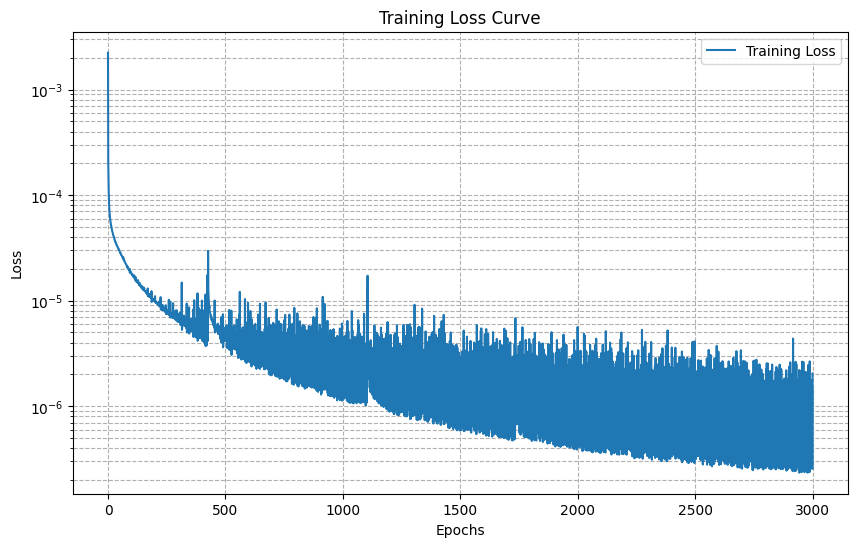

In [98]:
import matplotlib.pyplot as plt

# Example training loss data as a list


# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss_store, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


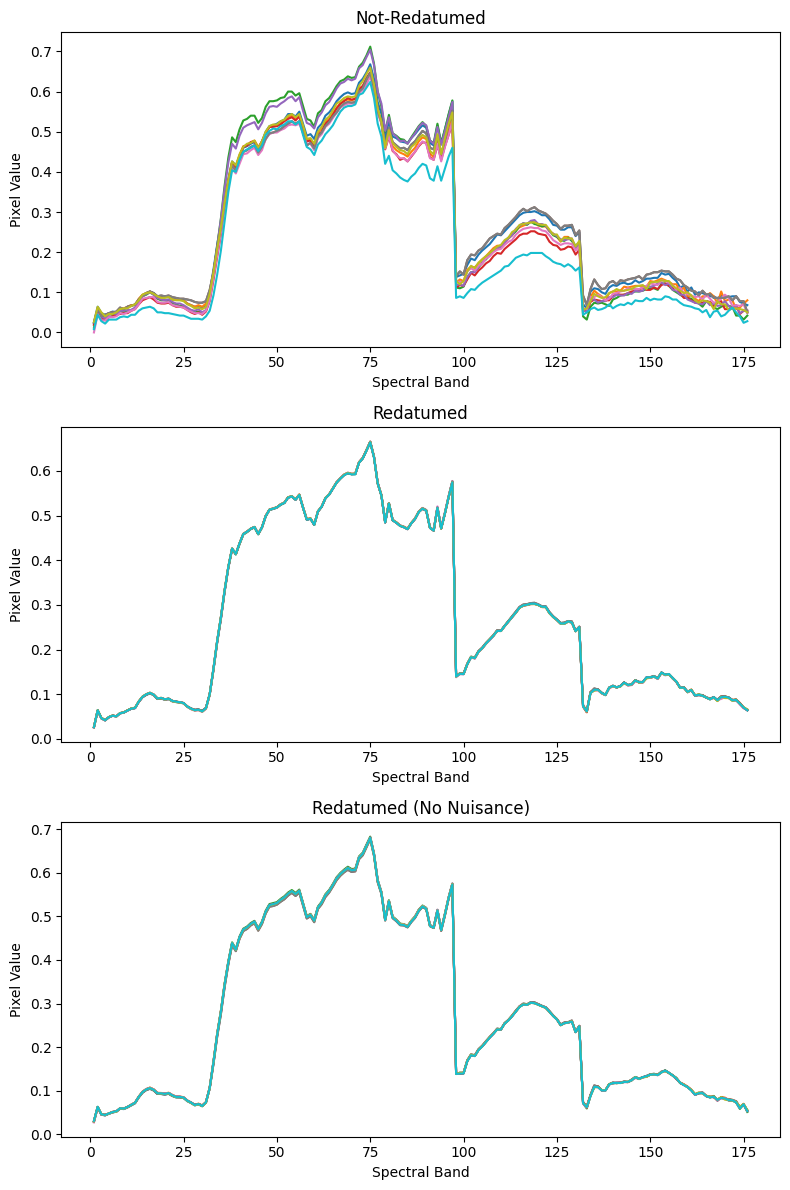

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt


# Randomly select a class
j = np.random.choice(list(class_dict.keys()))
class_pixels = class_dict[j]

# Randomly select 10 pixels from the class
indices = np.random.choice(len(class_pixels), 10, replace=True)
ab = class_pixels[indices]

# Move the data to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ab_tensor = torch.from_numpy(ab).to(device)

# Pass the data through the encoder and decoder
with torch.no_grad():
    nuis = model.nenc(ab_tensor[0, :])
    coh = model.cenc(ab_tensor)
    mmm = torch.ones(10, 1).to(device)
    nnn = nuis * mmm
    kkk = torch.cat((coh, nnn), dim=1)
    lll = model.dec(kkk)

# Move the results back to the CPU for plotting
ab_cpu = ab_tensor.cpu().numpy()
lll_cpu = lll.cpu().numpy()

# Plot the original and redatumed data
plt.figure(figsize=(8, 12))

plt.subplot(3, 1, 1)
plt.plot(range(1, 177), ab_cpu.T)
plt.title("Not-Redatumed")
plt.xlabel("Spectral Band")
plt.ylabel("Pixel Value")

plt.subplot(3, 1, 2)
plt.plot(range(1, 177), lll_cpu.T)
plt.title("Redatumed")
plt.xlabel("Spectral Band")
plt.ylabel("Pixel Value")

plt.subplot(3, 1, 3)
with torch.no_grad():
    redatumed_no_nuis = model.dec(torch.cat((coh, torch.zeros_like(nnn)), dim=1))
redatumed_no_nuis_cpu = redatumed_no_nuis.cpu().numpy()
plt.plot(range(1, 177), redatumed_no_nuis_cpu.T)
plt.title("Redatumed (No Nuisance)")
plt.xlabel("Spectral Band")
plt.ylabel("Pixel Value")

plt.tight_layout()
plt.show()

In [6]:
test_dict = create_class_dict(HSI, test_coords)

In [7]:
train_dict = create_class_dict(HSI, train_coords)

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the classification model
class ClassificationModel(nn.Module):
    def __init__(self, ncc):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(ncc, 8 * 128)
        self.relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(8 * 128, 4 * 128)
        self.relu2 = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(4 * 128, 64)
        self.relu3 = nn.LeakyReLU()
        self.fc4 = nn.Linear(64, 13)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.relu3(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

# Assuming you have the trained SYMAE model, the training data dictionary (train_dict),
# and the test data dictionary (test_dict)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
# Create an instance of the classification model
cmodel = ClassificationModel(nc).to(device)

In [110]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cmodel.parameters(), lr=0.0001)

In [90]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cmodel.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


In [111]:
# Concatenate all training pixels and labels
train_pixels = []
train_labels = []
for class_label, pixels in train_dict.items():
    train_pixels.append(pixels)
    train_labels.extend([class_label] * len(pixels))

train_pixels = np.concatenate(train_pixels, axis=0)
train_labels = np.array(train_labels)

# Move the training data to the device
train_pixels_tensor = torch.from_numpy(train_pixels).float().to(device)
train_labels_tensor = torch.from_numpy(train_labels).long().to(device)

In [112]:
# Training loop
num_epochs = 1000
batch_size = 64

cmodel.train()

for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(train_pixels_tensor.size(0))
    train_pixels_tensor = train_pixels_tensor[perm]
    train_labels_tensor = train_labels_tensor[perm]

    # Iterate over batches
    for i in range(0, train_pixels_tensor.size(0), batch_size):
        # Get the batch
        batch_pixels = train_pixels_tensor[i:i+batch_size]
        batch_labels = train_labels_tensor[i:i+batch_size]

        # Adjust the labels to 0-based indexing
        batch_labels = batch_labels - 1

        # Pass the batch pixels through the SYMAE model to get the latent representations
        latent_repr = model.cenc(batch_pixels)

        # Forward pass
        outputs = cmodel(latent_repr)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the training loss for every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 1.7943
Epoch [200/1000], Loss: 1.7355
Epoch [300/1000], Loss: 1.7263
Epoch [400/1000], Loss: 1.7043
Epoch [500/1000], Loss: 1.7348
Epoch [600/1000], Loss: 1.6892
Epoch [700/1000], Loss: 1.6892
Epoch [800/1000], Loss: 1.6891
Epoch [900/1000], Loss: 1.6891
Epoch [1000/1000], Loss: 1.6891


In [113]:
cmodel.eval()

ClassificationModel(
  (fc1): Linear(in_features=64, out_features=1024, bias=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (fc4): Linear(in_features=64, out_features=13, bias=True)
  (softmax): Softmax(dim=1)
)

In [114]:
# Evaluation on the test set
test_pixels = []
test_labels = []
for class_label, pixels in test_dict.items():
    test_pixels.append(pixels)
    test_labels.extend([class_label] * len(pixels))

test_pixels = np.concatenate(test_pixels, axis=0)
test_labels = np.array(test_labels)

# Adjust the test labels to 0-based indexing
test_labels = test_labels - 1

test_pixels_tensor = torch.from_numpy(test_pixels).float().to(device)
test_labels_tensor = torch.from_numpy(test_labels).long().to(device)

model.eval()
with torch.no_grad():
    latent_repr = model.cenc(test_pixels_tensor)
    outputs = cmodel(latent_repr)
    _, predicted = torch.max(outputs, 1)

predicted_cpu = predicted.cpu().numpy()
test_labels_cpu = test_labels_tensor.cpu().numpy()

accuracy = accuracy_score(test_labels_cpu, predicted_cpu)
precision = precision_score(test_labels_cpu, predicted_cpu, average='weighted')
recall = recall_score(test_labels_cpu, predicted_cpu, average='weighted')
f1 = f1_score(test_labels_cpu, predicted_cpu, average='weighted')

print("Classification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Classification Metrics:
Accuracy: 0.9231
Precision: 0.9248
Recall: 0.9231
F1-score: 0.9232
